In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import load_data as ld
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models
print(tf.__version__)

2.6.0


In [2]:
ip_data = np.load("../data/1988_lanina_ip_sp.npy")[[7]]

In [3]:
model = keras.models.load_model("../data/model/exp2_pretrain_op1_sp2")

In [4]:
model.predict(ip_data)

array([[-0.9271177]], dtype=float32)

In [5]:
model.layers[-1].get_weights()[0][:10]

array([[-0.05980455],
       [ 0.03064999],
       [ 0.03762075],
       [ 0.02403995],
       [-0.10953056],
       [-0.04573866],
       [-0.1072132 ],
       [-0.13663232],
       [ 0.12657101],
       [-0.04962987]], dtype=float32)

In [6]:
last_conv_layer_name = "conv2d_2"
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)
grad_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 24, 72, 6)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 72, 30)        5790      
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 36, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 36, 30)        28830     
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 18, 30)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 18, 30)         28830     
_________________________________________________________________
flatten (Flatten)            (None, 3240)              0     

In [7]:
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(ip_data)
    class_channel = preds[:,0]
grads = tape.gradient(class_channel, last_conv_layer_output)
grads.shape,preds.shape

(TensorShape([1, 6, 18, 30]), TensorShape([1, 1]))

In [8]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
# pooled_grads = grads
grads.shape,pooled_grads.shape

(TensorShape([1, 6, 18, 30]), TensorShape([30]))

In [9]:
last_conv_layer_output = last_conv_layer_output[0]

In [10]:
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]

In [11]:
heatmap.shape

TensorShape([6, 18, 1])

In [1]:
heatmap = tf.squeeze(heatmap)
heatmap.shape

NameError: name 'tf' is not defined

d:\anacoda\lib\site-packages\cartopy\mpl\geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


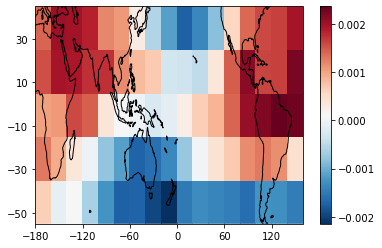

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

x = np.arange(0,356,5)[::4]
y = np.arange(-55,61,5)[::4]
x1 = np.arange(0, 356, 5)
y1 = np.arange(-55, 61, 5)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
draw_s = np.copy(ip_data[0, :, :, 1])
draw_s[draw_s == 0] = np.NAN

m = ax.pcolor(x,y,heatmap,cmap="RdBu_r",transform=ccrs.PlateCarree())
# m = ax.contour(x1, y1, draw_s, transform=ccrs.PlateCarree(),levels=np.linspace(-5,5,13),colors='k')
# ax.clabel(m, fmt="%.2f")
plt.colorbar(m)
ax.set_aspect("auto")
xtk = np.arange(-180,180,60)
ax.set_xticks(xtk,crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-50,50,20),crs=ccrs.PlateCarree())
ax.coastlines()

In [51]:
x = np.arange(0,356,5)[::4]
y = np.arange(-55,61,5)[::4]
x.shape,y.shape

((18,), (6,))

In [70]:
# np.save("../data/heatmap_1_res",heatmap)

In [16]:
model.get_layer(last_conv_layer_name).bias

<tf.Variable 'conv2d_2/bias:0' shape=(30,) dtype=float32, numpy=
array([-0.01725547, -0.02233502,  0.04570964,  0.07476381, -0.0878713 ,
       -0.03070524,  0.02885108,  0.01472273,  0.09854175,  0.08743952,
       -0.07198367,  0.00676345,  0.02504964,  0.01731011,  0.11951797,
        0.09742937, -0.12043753, -0.02078011,  0.07357337, -0.02314911,
       -0.10075808,  0.01381184, -0.01101726, -0.01395467,  0.08731153,
       -0.06165177, -0.04790077,  0.01655333,  0.11790548,  0.21389608],
      dtype=float32)>